# Airbnb - Data Modeling & Evaluation (Vancouver / Toronto)

## Imports

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
from sklearn.pipeline import Pipeline
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import date
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone 
from sklearn.preprocessing import MultiLabelBinarizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Functions

In [ ]:
def plot_histogram(data, column, market, ax, binsize=50, y_label='', x_label='', color='blue'):

    sns.distplot(data[column], kde=False, color=color, bins=binsize, ax=ax)
    ax.set_title(f"{market} {column} data", fontsize=25)
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_xlabel(x_label, fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
def plot_line(data, ax, color, alpha=.7, ls='-', lw=5, label=None):
    ax.plot(data, color=color,
            alpha=alpha, ls=ls,
            linewidth=lw, label=label)
    
def outlier_removal(data, column, outlier_pctile=5):
    df = data.copy()
    upper_theshold = np.percentile(df[column].values, 100-outlier_pctile)
    lower_theshold = np.percentile(df[column].values, outlier_pctile)
    df = df[df[column] >= lower_theshold]
    df = df[df[column] <= upper_theshold]
    
    return df      
    
def validation_metrics(predictions, test, baseline_mae='', baseline_mape=''):
    
    errors = abs(predictions - test)
    print('Mean Absolute error:', round(np.mean(errors), 2))
    mape = np.mean(100 * (errors / test))
    print('Mean Absolute Percentage error:', round(np.mean(mape), 2))
    accuracy = 100 - mape
    print('Accuracy:', round(accuracy, 2), '%.')
    if baseline_mae:
        improvement_baseline = mae - baseline_mae
        print('MAPE Improvement:', round(improvement_baseline, 2))    

    if baseline_mape:
        improvement_baseline = mape - baseline_mape
        print('MAPE Improvement:', round(improvement_baseline, 2), '%.')     

## Basic Setup (Read data, create global variables etc.)

In [ ]:
style.use('seaborn-poster') 
style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = "sans serif"

In [ ]:
vancouver_cal = pd.read_csv('drive/MyDrive/Dataset/Vcalendar.csv')
vancouver_list = pd.read_csv('drive/MyDrive/Dataset/Vlistings.csv')

toronto_cal = pd.read_csv('drive/MyDrive/Dataset/Tcalendar.csv')
toronto_list = pd.read_csv('drive/MyDrive/Dataset/Tlistings.csv')

In [ ]:
def data_cleaning_calendar(data):  
    data = data.dropna()  
    data.loc[:,'price'] = [int(str(x).replace('$','').replace(',','').replace('.00','')) 
                     for x in data['price']] 
    data.loc[:,'date'] = pd.to_datetime(data['date'])
    data = data[['listing_id','price','date']]
    return data


def data_cleaning_listings(data):
    keep_col = ['id','neighbourhood','property_type','room_type','accommodates','bathrooms',
                'bedrooms','beds','amenities','price','number_of_reviews','review_scores_rating',
                'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
                'review_scores_communication','review_scores_location','review_scores_value',
                'reviews_per_month']

    data = data[keep_col]
    data_dpcol = data.dropna(axis=1, thresh=len(data)*0.1)
    dropped_col = set(data.columns).difference(list(data_dpcol.columns))
    data_fil = data_dpcol.dropna(axis=0, thresh=1)
    price_columns = ['price']

    for column in price_columns:
        data_fil.loc[:,column] = data_fil[column].fillna(0)
        data_fil.loc[:,column] = [int(str(x).replace('$','').replace(',','').replace('.00','')) 
                            for x in data_fil[column]]
    return data_fil

In [ ]:

cleaned_calendar_vancouver = data_cleaning_calendar(vancouver_cal)
cleaned_calendar_toronto = data_cleaning_calendar(toronto_cal)

cleaned_listing_vancouver = data_cleaning_listings(vancouver_list)
cleaned_listing_toronto = data_cleaning_listings(toronto_list)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
def join_data(calendar_data, listings_data):
    calendar_data = calendar_data.groupby('listing_id').median().round()    
    calendar_data = calendar_data[['price']]
    calendar_data.columns = ['Cal_price']
    listings_data.index = listings_data['id']
    listings_data = listings_data.drop(columns=['id'])
    merged_data = pd.merge(calendar_data, listings_data, left_index=True, right_index=True)
    return merged_data

In [ ]:
data_merged_vancouver = join_data(cleaned_calendar_vancouver, cleaned_listing_vancouver)
data_merged_toronto = join_data(cleaned_calendar_toronto, cleaned_listing_toronto)

In [ ]:
data_drop_vancouver = data_merged_vancouver.drop(columns=['price','neighbourhood'])
data_drop_toronto = data_merged_toronto.drop(columns=['price','neighbourhood'])

In [ ]:
def preprocessing(data_drop):
    numeric_cata = ['review_scores_rating','accommodates','bedrooms','beds',
                    'review_scores_accuracy','review_scores_cleanliness',
                    'review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value']
    data_drop[numeric_cata] = data_drop[numeric_cata].fillna(data_drop.mode().iloc[0])
    rev_col = ['reviews_per_month']
    data_drop[rev_col] = data_drop[rev_col].fillna(data_drop[rev_col].median().round())
    data_drop = data_drop.dropna()
    data_drop['amenities'] = [x.replace('{','').replace('}','').replace('"','').split(',') 
                                 for x in data_drop['amenities']]
    mlb = MultiLabelBinarizer()
    amenities = pd.DataFrame(mlb.fit_transform(data_drop.pop('amenities')),
                              columns=mlb.classes_,
                              index=data_drop.index)
    non_numeric_cata = ['property_type', 'room_type']
    nn_cata = pd.get_dummies(data_drop[non_numeric_cata])
    data_temp = pd.merge(data_drop, nn_cata, left_index=True, right_index=True)
    data_output =  pd.merge(data_temp, amenities, left_index=True, right_index=True)
    data_output = data_output.drop(columns=['property_type', 'room_type',''], errors='ignore')
    
    return data_output

In [ ]:
vancouver_input = preprocessing(data_drop_vancouver)
toronto_input = preprocessing(data_drop_toronto)

In [ ]:
toronto_input.shape

(15832, 702)

# Data Modeling

In [ ]:
X_van = vancouver_input.iloc[:,1:]
Y_van = vancouver_input.iloc[:,0].values
X_to = toronto_input.iloc[:,1:]
Y_to = toronto_input.iloc[:,0].values

X_van_train, X_van_test, y_van_train, y_van_test = train_test_split(X_van, Y_van, test_size=0.3)
X_to_train, X_to_test, y_to_train, y_to_test = train_test_split(X_to, Y_to, test_size=0.3)

In [ ]:
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)

parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_van_train, y_van_train)
y_van_pred = reg.best_estimator_.predict(X_van_test)

print("\nOptimised Model [VANCOUVER]\n------")
print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_van_train, y_van_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_van_test, y_van_test)}')

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 11.9min finished



Optimised Model [VANCOUVER]
------

Optimised Model
------
RMSE Train Score: 0.7185504854178058
RMSE Test Score: 0.26302164806460737


In [ ]:
errors = abs(y_van_pred - y_van_test)
print('Average absolute error:', round(np.mean(errors), 2))
mae = np.mean(errors)
print('Mean Absolute error:', round(np.mean(mae), 2))
mape = np.mean(100 * (errors / y_van_test))
print('Mean Absolute Percentage error:', round(np.mean(mape), 2))
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')
mae_baseline = mae
mape_baseline = mape

Average absolute error: 58.72
Mean Absolute error: 58.72
Mean Absolute Percentage error: 34.85
Accuracy: 65.15 %.


In [ ]:
vancouver_ro = outlier_removal(vancouver_input, 'Cal_price', outlier_pctile=5)

X = vancouver_ro.iloc[:,1:]
Y = vancouver_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_train, y_train)
y_pred = reg.best_estimator_.predict(X_test)

print("\nOptimised Model [Vancouver]\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')

validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.7min finished



Optimised Model [Vancouver]
------
RMSE Train Score: 0.8805962665534981
RMSE Test Score: 0.4767987062178758
Mean Absolute error: 38.27
Mean Absolute Percentage error: 31.51
Accuracy: 68.49 %.
MAPE Improvement: 0.0
MAPE Improvement: -5.87 %.


In [ ]:
StdSclr = StandardScaler()
vancouver_sc = pd.DataFrame(StdSclr.fit_transform(vancouver_ro))
X = vancouver_sc.iloc[:,1:]
Y = vancouver_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_train, y_train)
y_pred = reg.best_estimator_.predict(X_test)
print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')
validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.7min finished



Optimised Model
------
RMSE Train Score: 0.881503996646151
RMSE Test Score: 0.4299837375591029
Mean Absolute error: 39.76
Mean Absolute Percentage error: 30.42
Accuracy: 69.58 %.
MAPE Improvement: 0.0
MAPE Improvement: 1.12 %.


In [ ]:
def RF_price_model(X_model_input, Y_model_input):
    # Set the X & Y variables
    X = X_model_input.iloc[:,1:]
    Y = Y_model_input.iloc[:,0].values

    # split into training & testing data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    
    # setup the random forests classifier
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)

    # train classifier
    rf.fit(X_train, y_train)

    # predict on test data
    y_pred = rf.predict(X_test)

    print("\nOptimised Model\n------")
    print(f'RMSE Train Score: {rf.score(X_train, y_train)}')
    print(f'RMSE Test Score: {rf.score(X_test,y_test)}')
    
    validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)
    
    return rf, X_train, y_train

In [ ]:
mape_baseline = 0
mae_baseline = 0
vancouver_ro = outlier_removal(vancouver_input, 'Cal_price', outlier_pctile=5)
StdSclr = StandardScaler()
vancouver_sc = pd.DataFrame(StdSclr.fit_transform(vancouver_ro))
best_model_va, X_train, y_train = RF_price_model(vancouver_sc, vancouver_ro)


Optimised Model
------
RMSE Train Score: 0.8187539348688107
RMSE Test Score: 0.47445433820290306
Mean Absolute error: 38.74
Mean Absolute Percentage error: 29.21
Accuracy: 70.79 %.


In [ ]:
plt.figure(figsize=(12,10))
cor = vancouver_input.corr()
cor_target = abs(cor["Cal_price"])
cor_target


Cal_price                          1.000000
accommodates                       0.496760
bedrooms                           0.476895
beds                               0.428104
number_of_reviews                  0.034842
                                     ...   
[Suitable for events               0.002373
[TV                                0.014096
[Washer                            0.014984
[Washer \u2013\u00a0In building    0.001238
[Wifi                              0.028904
Name: Cal_price, Length: 527, dtype: float64

<Figure size 864x720 with 0 Axes>

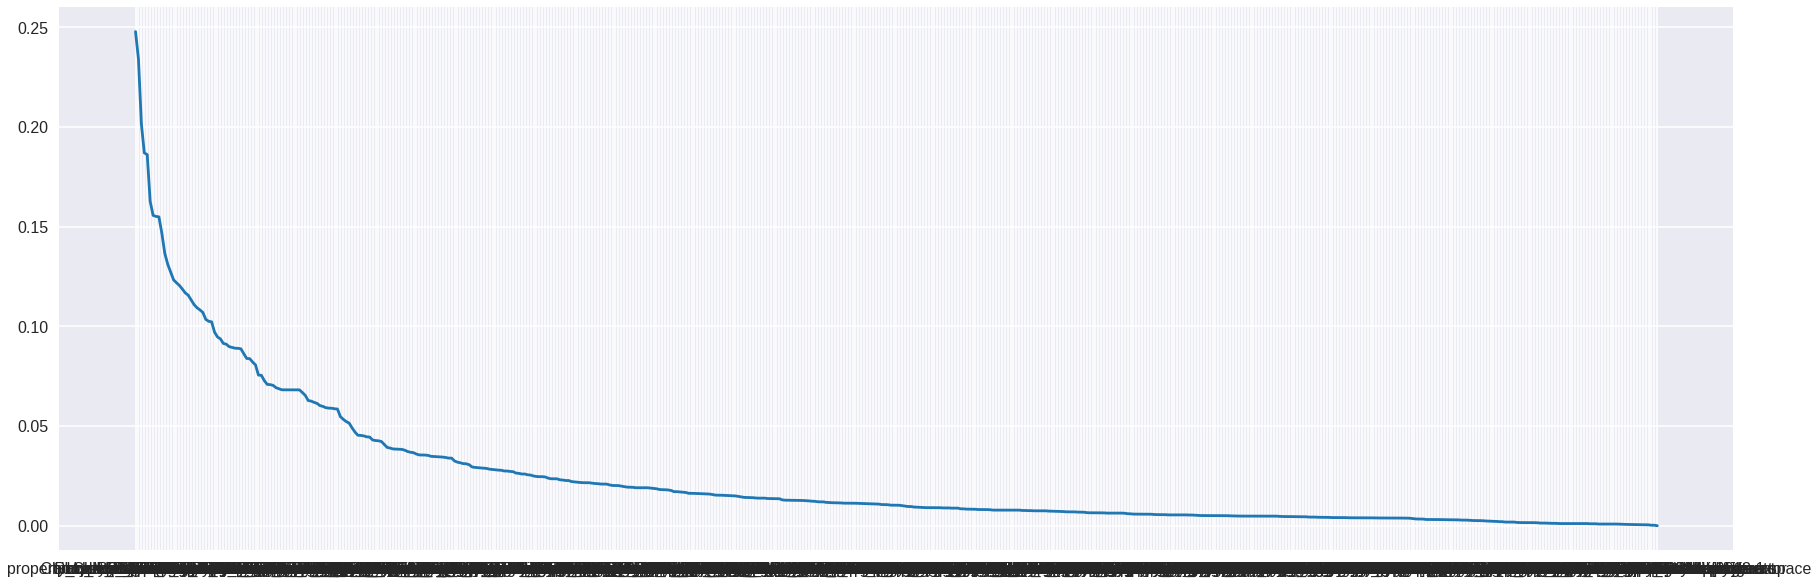

In [ ]:
cor_target = cor_target.sort_values(ascending=False)[1:]
plt.figure(figsize=(30, 10))
plt.plot(cor_target)
# plt.xticks(rotation=90)


In [ ]:
relevant_features = cor_target[cor_target>0.05]

In [ ]:
relevant_features.shape

(80,)

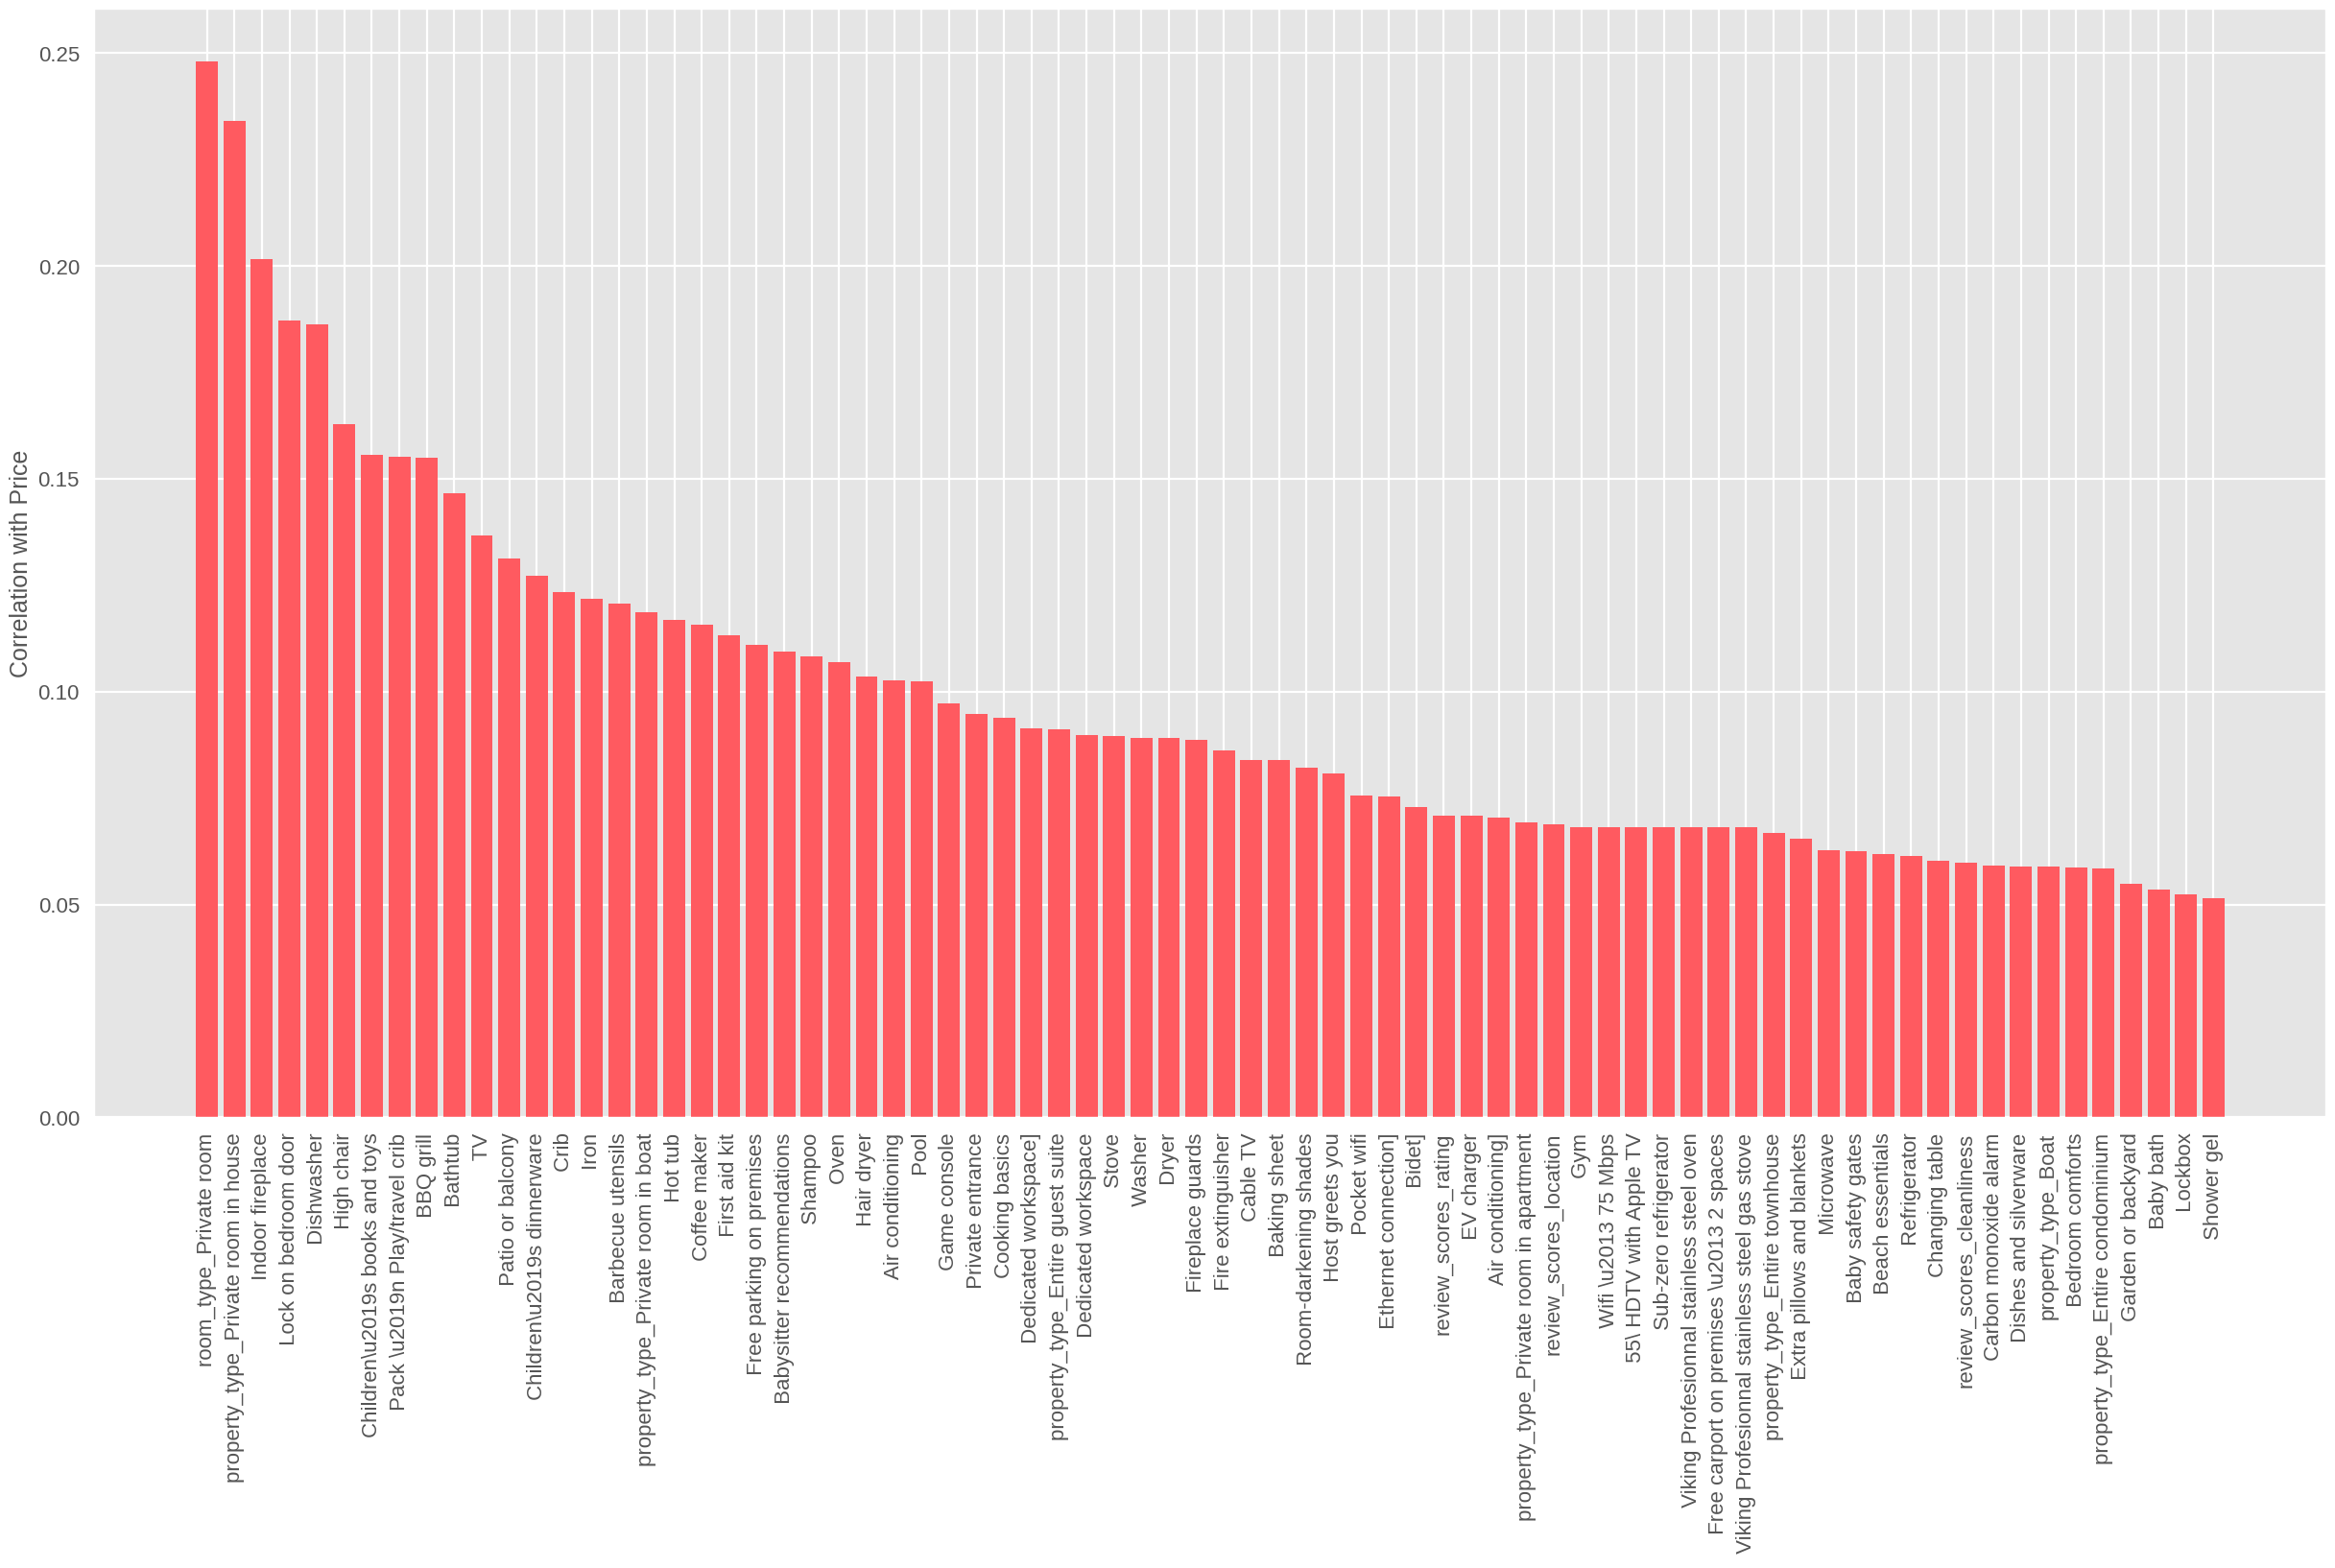

In [ ]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = "sans serif"
plt.figure(figsize=(30, 15))
plt.bar(relevant_features.index,relevant_features,color='#FF5A60')
plt.xticks(rotation=90)
plt.ylabel('Correlation with Price', fontsize=18)
plt.show()

In [ ]:
relevant_features_label = list(relevant_features.index)
vancouver_ro_limit_features = vancouver_ro[relevant_features.index]
StdSclr = StandardScaler()
vancouver_sc_limit_features = pd.DataFrame(StdSclr.fit_transform(vancouver_ro_limit_features))
X = vancouver_sc_limit_features.iloc[:,1:]
Y = vancouver_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_train, y_train)
y_pred = reg.best_estimator_.predict(X_test)
print("\nOptimised Model\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')
validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 174 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  3.5min finished



Optimised Model
------
RMSE Train Score: 0.7757656066572751
RMSE Test Score: 0.45033868974377067
Mean Absolute error: 39.88
Mean Absolute Percentage error: 30.41
Accuracy: 69.59 %.
MAPE Improvement: -55.63
MAPE Improvement: -6.96 %.


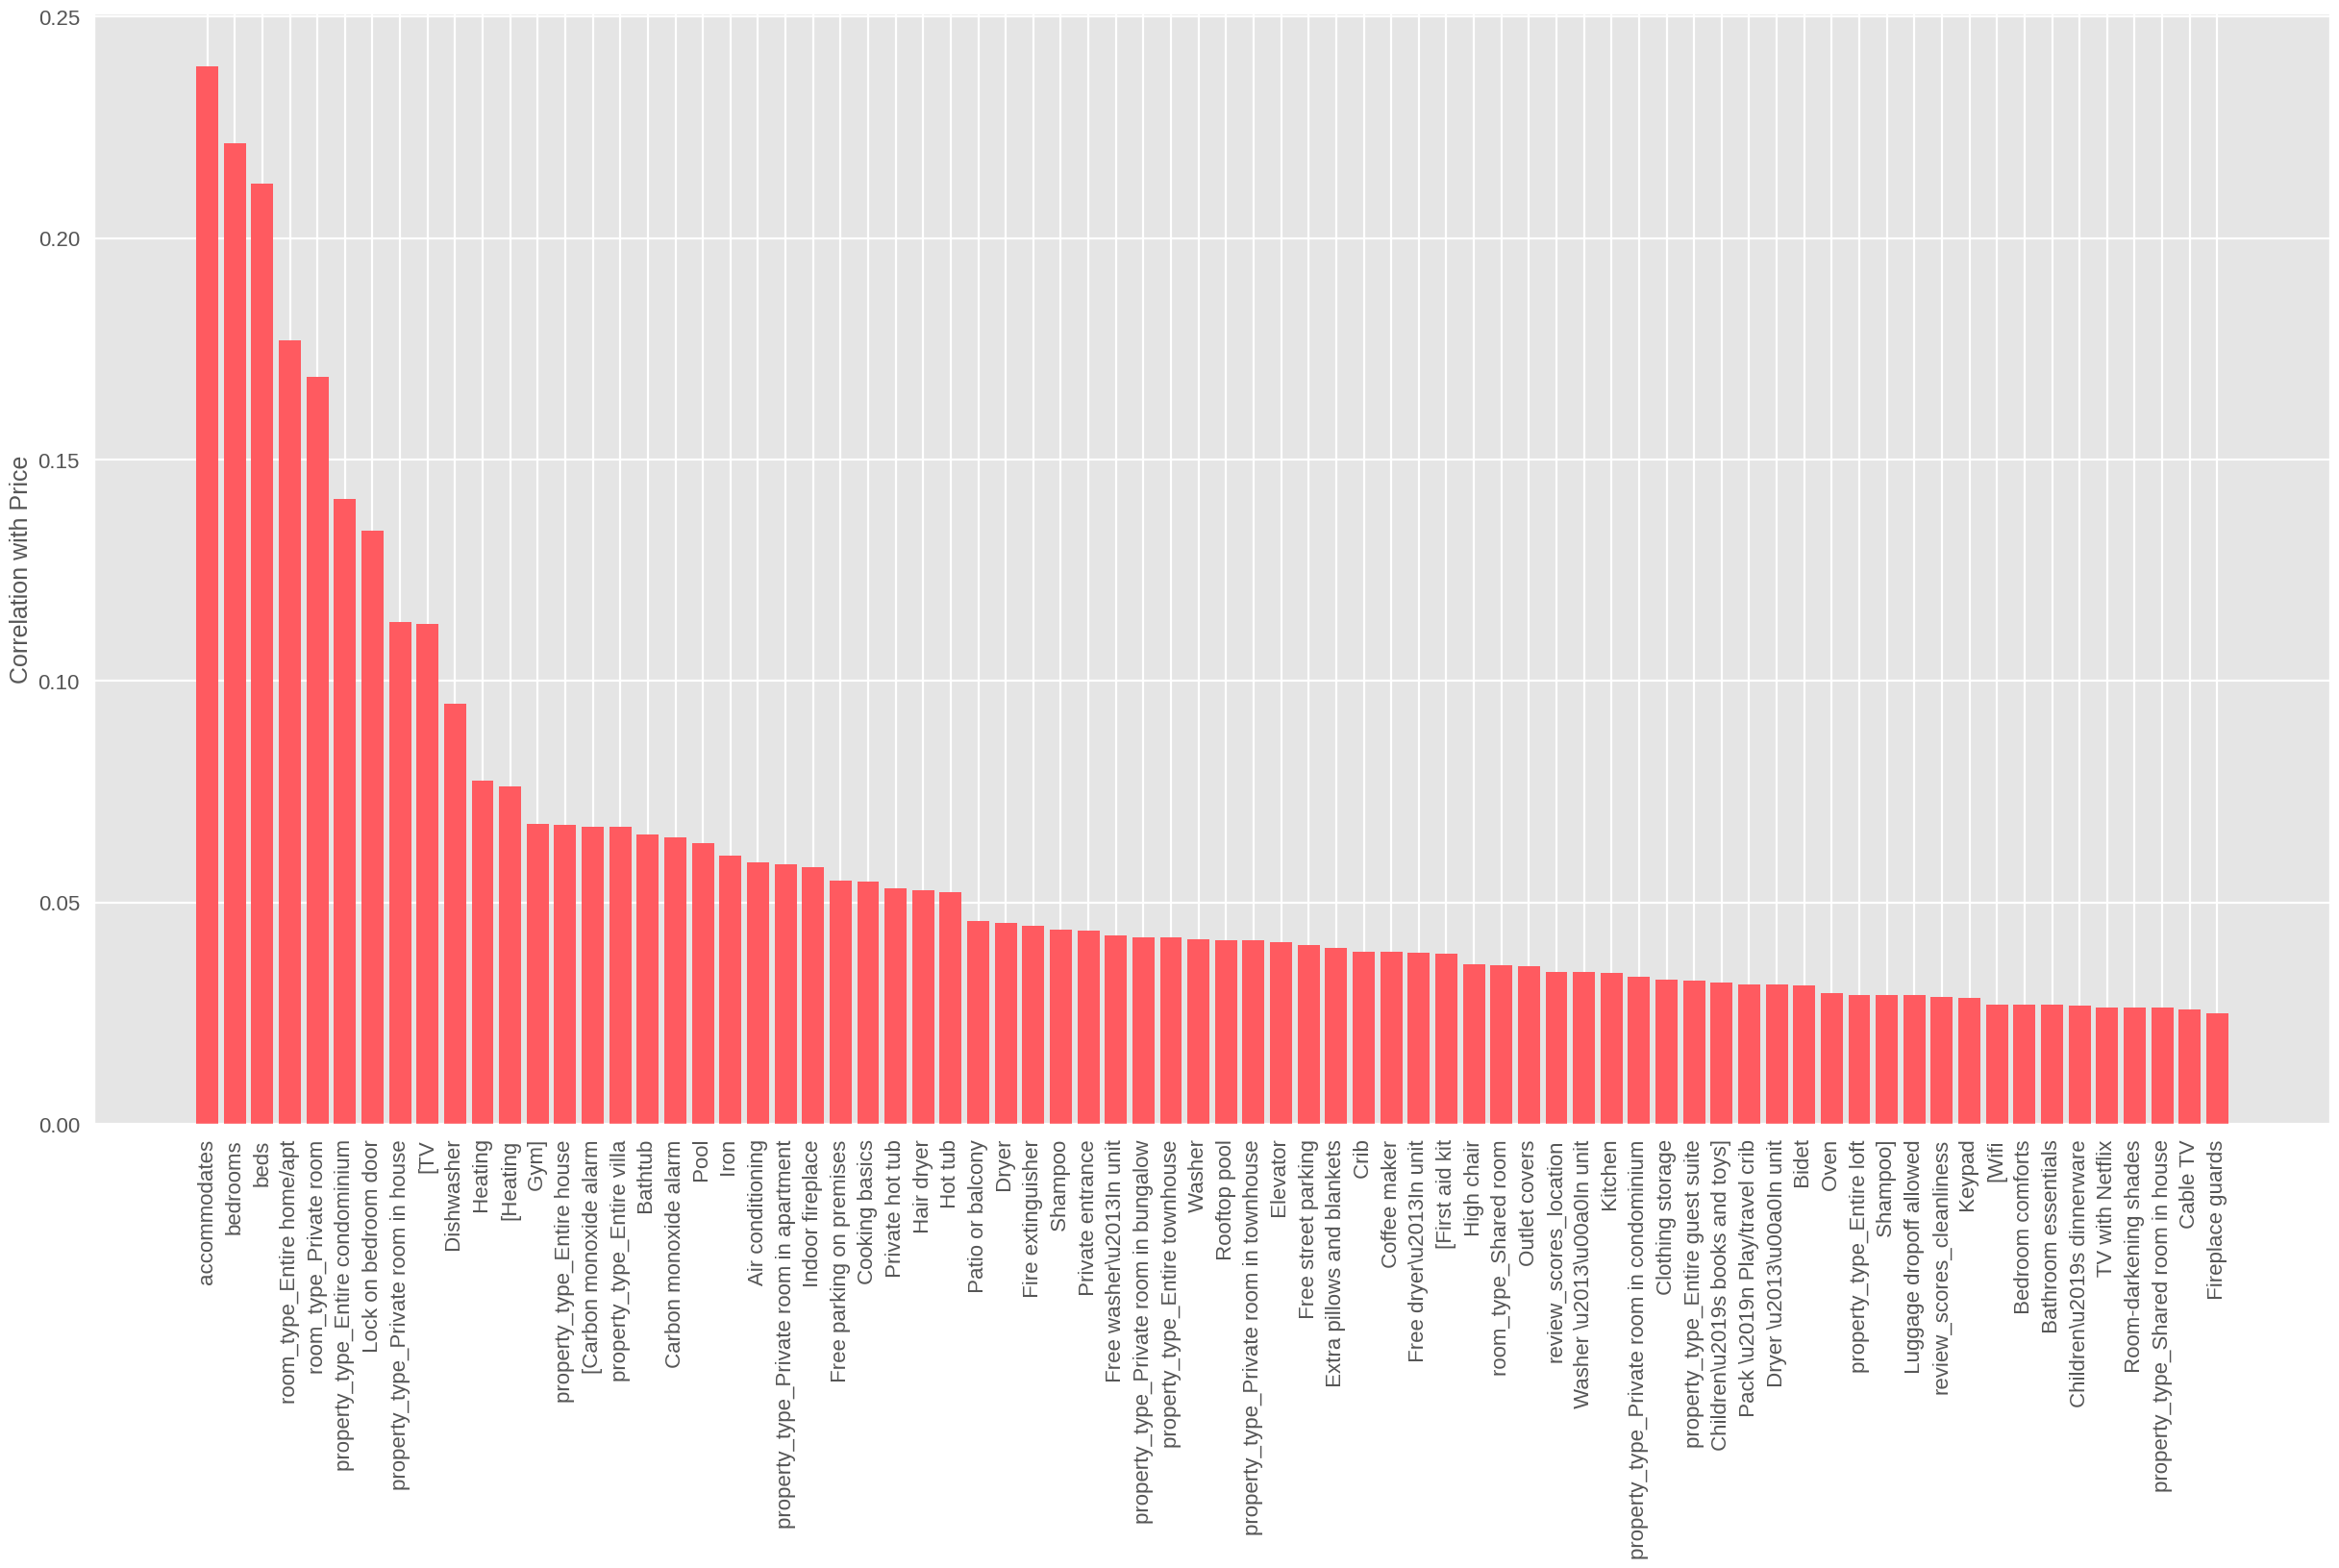

In [ ]:
cor_to = toronto_input.corr()
cor_target_to = abs(cor_to["Cal_price"])
cor_target_to = cor_target_to.sort_values(ascending=False)[1:]
relevant_features_to = cor_target_to[cor_target_to>0.025]


plt.style.use('ggplot')
plt.rcParams['font.family'] = "sans serif"
plt.figure(figsize=(30, 15))
plt.bar(relevant_features_to.index,relevant_features_to,color='#FF5A60')
plt.xticks(rotation=90)
plt.ylabel('Correlation with Price', fontsize=18)
plt.show()

In [ ]:
relevant_features_to

accommodates                          0.238777
bedrooms                              0.221354
beds                                  0.212398
room_type_Entire home/apt             0.177006
room_type_Private room                0.168652
                                        ...   
 TV with Netflix                      0.026288
 Room-darkening shades                0.026272
property_type_Shared room in house    0.026268
 Cable TV                             0.025833
 Fireplace guards                     0.025037
Name: Cal_price, Length: 74, dtype: float64

In [ ]:
mape_baseline = 0
mae_baseline = 0
toronto_ro = outlier_removal(toronto_input, 'Cal_price', outlier_pctile=5)
StdSclr = StandardScaler()
toronto_sc = pd.DataFrame(StdSclr.fit_transform(toronto_ro[list(relevant_features_to.index)]))
best_model_to, X_train, y_train = RF_price_model(toronto_sc, toronto_ro)


Optimised Model
------
RMSE Train Score: 0.7519171786181463
RMSE Test Score: 0.4665300507703068
Mean Absolute error: 35.96
Mean Absolute Percentage error: 33.71
Accuracy: 66.29 %.


In [ ]:
relevant_features_to.shape

(74,)

In [ ]:
toronto_ro = outlier_removal(toronto_input, 'Cal_price', outlier_pctile=5)
toronto_ro_limit_features = toronto_ro[relevant_features_to.index]
StdSclr = StandardScaler()
toronto_sc_limit_features = pd.DataFrame(StdSclr.fit_transform(toronto_ro_limit_features))
X = toronto_sc_limit_features.iloc[:,1:]
Y = toronto_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_train, y_train)
y_pred = reg.best_estimator_.predict(X_test)
print("\nOptimised Model [Toronto]\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')
validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 10.8min finished



Optimised Model [Toronto]
------
RMSE Train Score: 0.7502167763137326
RMSE Test Score: 0.4602112625711293
Mean Absolute error: 35.18
Mean Absolute Percentage error: 33.34
Accuracy: 66.66 %.
MAPE Improvement: -55.63
MAPE Improvement: -4.03 %.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pca = PCA(n_components=50)
X_to_reduced = pca.fit_transform(scale(toronto_ro.iloc[:,1:]))
Y = toronto_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X_to_reduced, Y, test_size=0.2)
rf = RandomForestRegressor(oob_score=True, bootstrap=True, random_state=14)
parameters = {
    'n_estimators': [1,2,10,50,100,200],
    'min_samples_leaf':[1,2,3],
    'min_samples_split': [2,3,4],
}
reg = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, verbose=2, cv=5)
reg.fit(X_train, y_train)
y_pred = reg.best_estimator_.predict(X_test)
print("\nOptimised Model [Toronto]\n------")
print(f'RMSE Train Score: {reg.best_estimator_.score(X_train, y_train)}')
print(f'RMSE Test Score: {reg.best_estimator_.score(X_test, y_test)}')
validation_metrics(y_pred, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 47.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 82.7min finished



Optimised Model [Toronto]
------
RMSE Train Score: 0.8725363084737929
RMSE Test Score: 0.4410155276352511
Mean Absolute error: 36.39
Mean Absolute Percentage error: 35.35
Accuracy: 64.65 %.
MAPE Improvement: -55.63
MAPE Improvement: -2.03 %.


In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

toronto_ro = outlier_removal(toronto_input, 'Cal_price', outlier_pctile=5)
toronto_ro_limit_features = toronto_ro[relevant_features_to.index]
StdSclr = StandardScaler()
toronto_sc_limit_features = pd.DataFrame(StdSclr.fit_transform(toronto_ro_limit_features))
X = toronto_sc_limit_features.iloc[:,1:]
Y = toronto_ro.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)
rfe = RFE(estimator=model, n_features_to_select=50)

pipeline = Pipeline(steps=[('s',rfe),('m',model)])
pipeline.fit(X_train, y_train)
yhat = pipeline.predict(X_test)
print("\nOptimised Model [Toronto]\n------")
validation_metrics(yhat, y_test, baseline_mae=mae_baseline, baseline_mape=mape_baseline)


Optimised Model [Toronto]
------
Mean Absolute error: 35.37
Mean Absolute Percentage error: 34.39
Accuracy: 65.61 %.


In [ ]:
important_features = []
for i in range(X_train.shape[1]):
  if rfe.ranking_[i] == 1:
    important_features.append(i+1)
	# print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

# Evaluation

In [ ]:
def feature_importance(model, X_train, y_train, input_data,columns, rand_state):

    feat_imp = []
    mod_clone = clone(model)
    mod_clone.random_state = rand_state
    mod_clone.fit(X_train, y_train)
    mod_score = mod_clone.score(X_train, y_train)
    for col in X_train.columns:
        X_input = X_train.drop(columns=[col])
        print("Testing Features:")
        print(col)
        new_mod = clone(model)
        new_mod.random_state = rand_state
        new_mod.fit(X_input, y_train)
        update_score = new_mod.score(X_input, y_train)
        print(f'RMSE Train Score: {update_score}')
        feat_imp.append(mod_score - update_score)
    
    importances_df = pd.DataFrame(feat_imp, index=input_data.columns)
    
    return importances_df


In [ ]:

importance = feature_importance(best_model_to, X_train, y_train, toronto_ro_limit_features.iloc[:,1:],toronto_ro_limit_features.columns, 14)

Testing Features:
1
RMSE Train Score: 0.7382254623313802
Testing Features:
2
RMSE Train Score: 0.7394154020900425
Testing Features:
3
RMSE Train Score: 0.7514289040460611
Testing Features:
4
RMSE Train Score: 0.7518743469857214
Testing Features:
5
RMSE Train Score: 0.7436148468427289
Testing Features:
6
RMSE Train Score: 0.7483578284745129
Testing Features:
7
RMSE Train Score: 0.7498080256271709
Testing Features:
8
RMSE Train Score: 0.7487537699459094
Testing Features:
9
RMSE Train Score: 0.7508551584728272
Testing Features:
10
RMSE Train Score: 0.75140361244897
Testing Features:
11
RMSE Train Score: 0.751624706913746
Testing Features:
12
RMSE Train Score: 0.7488435969733781
Testing Features:
13
RMSE Train Score: 0.7486559537945975
Testing Features:
14
RMSE Train Score: 0.7515960699990263
Testing Features:
15
RMSE Train Score: 0.7518563886472692
Testing Features:
16
RMSE Train Score: 0.7492465796100691
Testing Features:
17
RMSE Train Score: 0.74661114949875
Testing Features:
18
RMSE Tr

In [ ]:
def plot_feature_importance(feat_importance):
    fig, ax = plt.subplots(figsize=(18,9))
    sorted_imp = feat_importance.sort_values(0, ascending=False)
    x = range(1,len(sorted_imp)+1)
    y = sorted_imp.values
    import seaborn as sns
    ax.vlines(x=x, ymin=0, ymax=y, color='green', alpha=0.4)
    ax.bar(x, y, color='green', alpha=1)
    plt.xticks(range(1,len(sorted_imp)+1), list(sorted_imp.index), rotation=89, fontsize=12)
    plt.tight_layout()
    

In [ ]:
importance.values.shape

(73, 1)

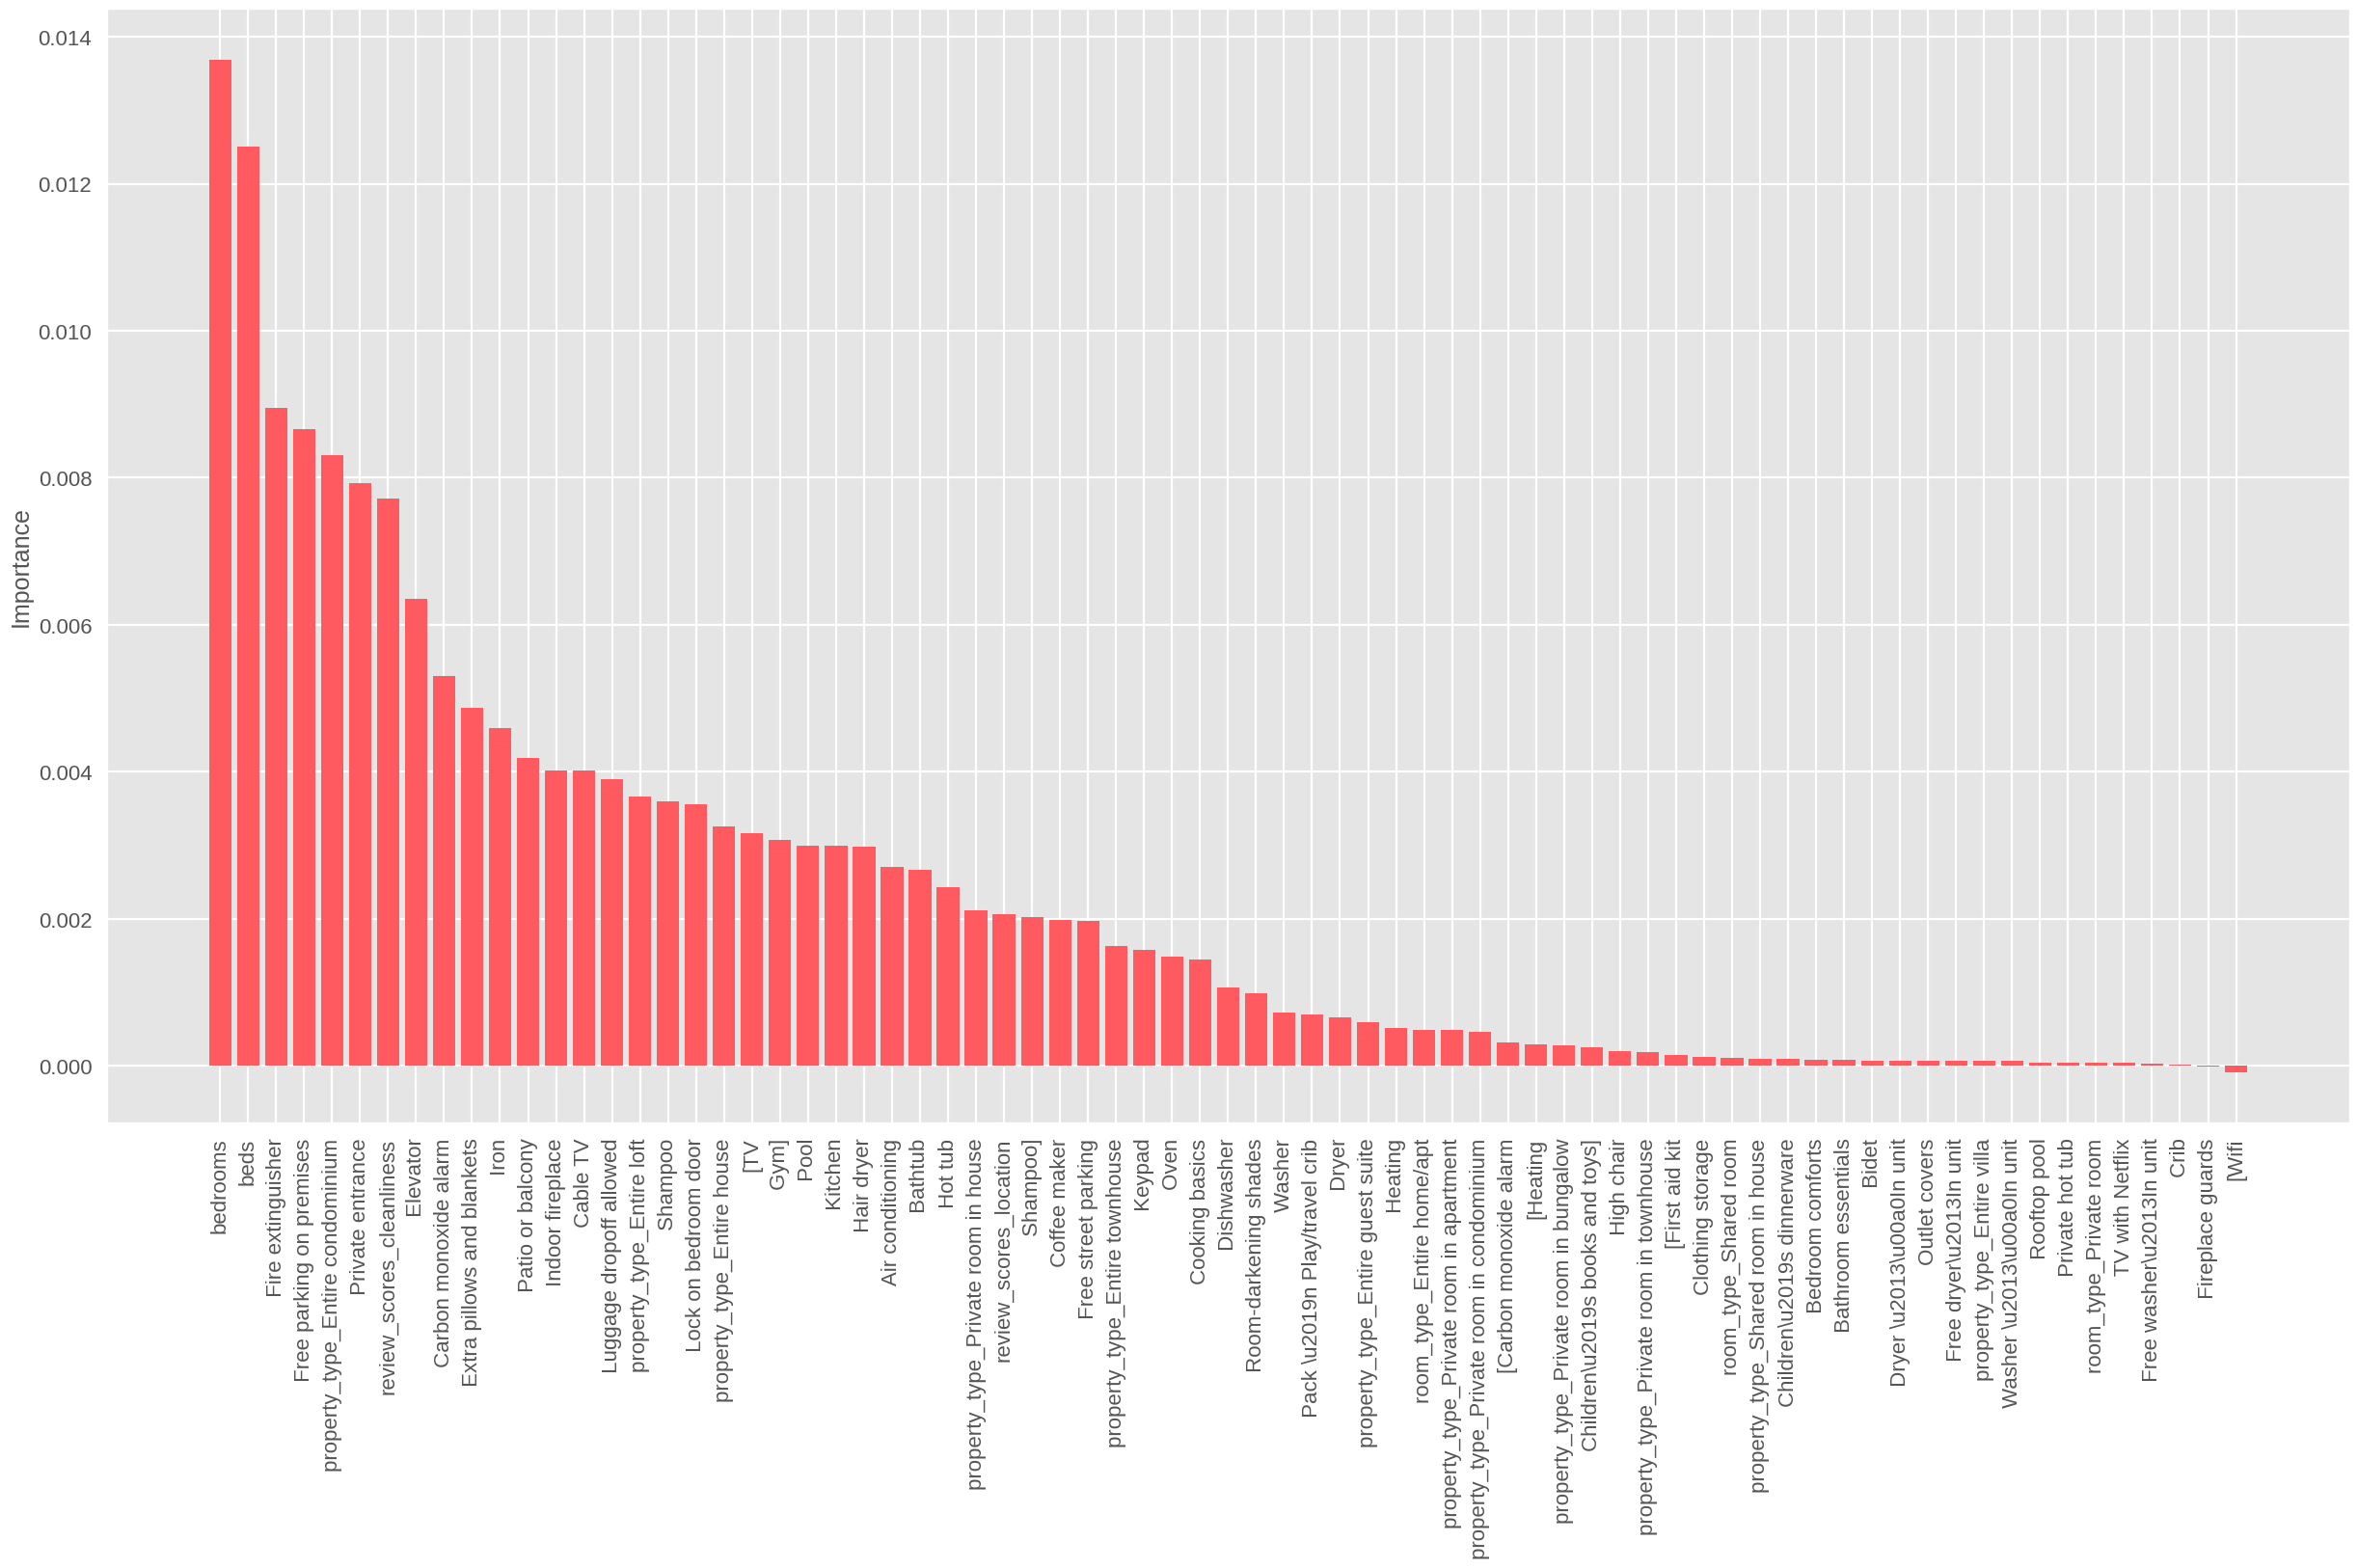

In [ ]:

# plot_feature_importance(importance)
importance_r = importance.loc[:,0].sort_values(ascending=False)
plt.style.use('ggplot')
plt.rcParams['font.family'] = "sans serif"
plt.figure(figsize=(30, 15))
plt.bar(importance_r.index,importance_r.values,color='#FF5A60')
plt.xticks(rotation=90)
plt.ylabel('Importance', fontsize=18)
plt.show()

In [ ]:
col_drop = list(importance[importance[0] < 0].index)
toronto_drop = toronto_ro_limit_features.drop(columns=col_drop)
StdSclr = StandardScaler()
toronto_sc_update = pd.DataFrame(StdSclr.fit_transform(toronto_drop))
new_rf, X_train, y_train = RF_price_model(toronto_sc_update, toronto_drop)


Optimised Model
------
RMSE Train Score: 0.8602849462016204
RMSE Test Score: 0.6777746827801866
Mean Absolute error: 0.66
Mean Absolute Percentage error: 26.67
Accuracy: 73.33 %.


In [ ]:
importance_updated = feature_importance(new_rf, X_train, y_train, toronto_drop.iloc[:,1:],list(X_train.columns), 14)

Testing Features:
1
RMSE Train Score: 0.839772236096684
Testing Features:
2
RMSE Train Score: 0.8179532435989096
Testing Features:
3
RMSE Train Score: 0.8599368983643877
Testing Features:
4
RMSE Train Score: 0.8602336499572044
Testing Features:
5
RMSE Train Score: 0.858228515762665
Testing Features:
6
RMSE Train Score: 0.8596256603787721
Testing Features:
7
RMSE Train Score: 0.8598893872462194
Testing Features:
8
RMSE Train Score: 0.8589666590733871
Testing Features:
9
RMSE Train Score: 0.8591983190174388
Testing Features:
10
RMSE Train Score: 0.8600616886239963
Testing Features:
11
RMSE Train Score: 0.8602532295070109
Testing Features:
12
RMSE Train Score: 0.8593520459261467
Testing Features:
13
RMSE Train Score: 0.8593164880127654
Testing Features:
14
RMSE Train Score: 0.860220778149762
Testing Features:
15
RMSE Train Score: 0.8603019023253601
Testing Features:
16
RMSE Train Score: 0.8587203760267629
Testing Features:
17
RMSE Train Score: 0.858111020822713
Testing Features:
18
RMSE T

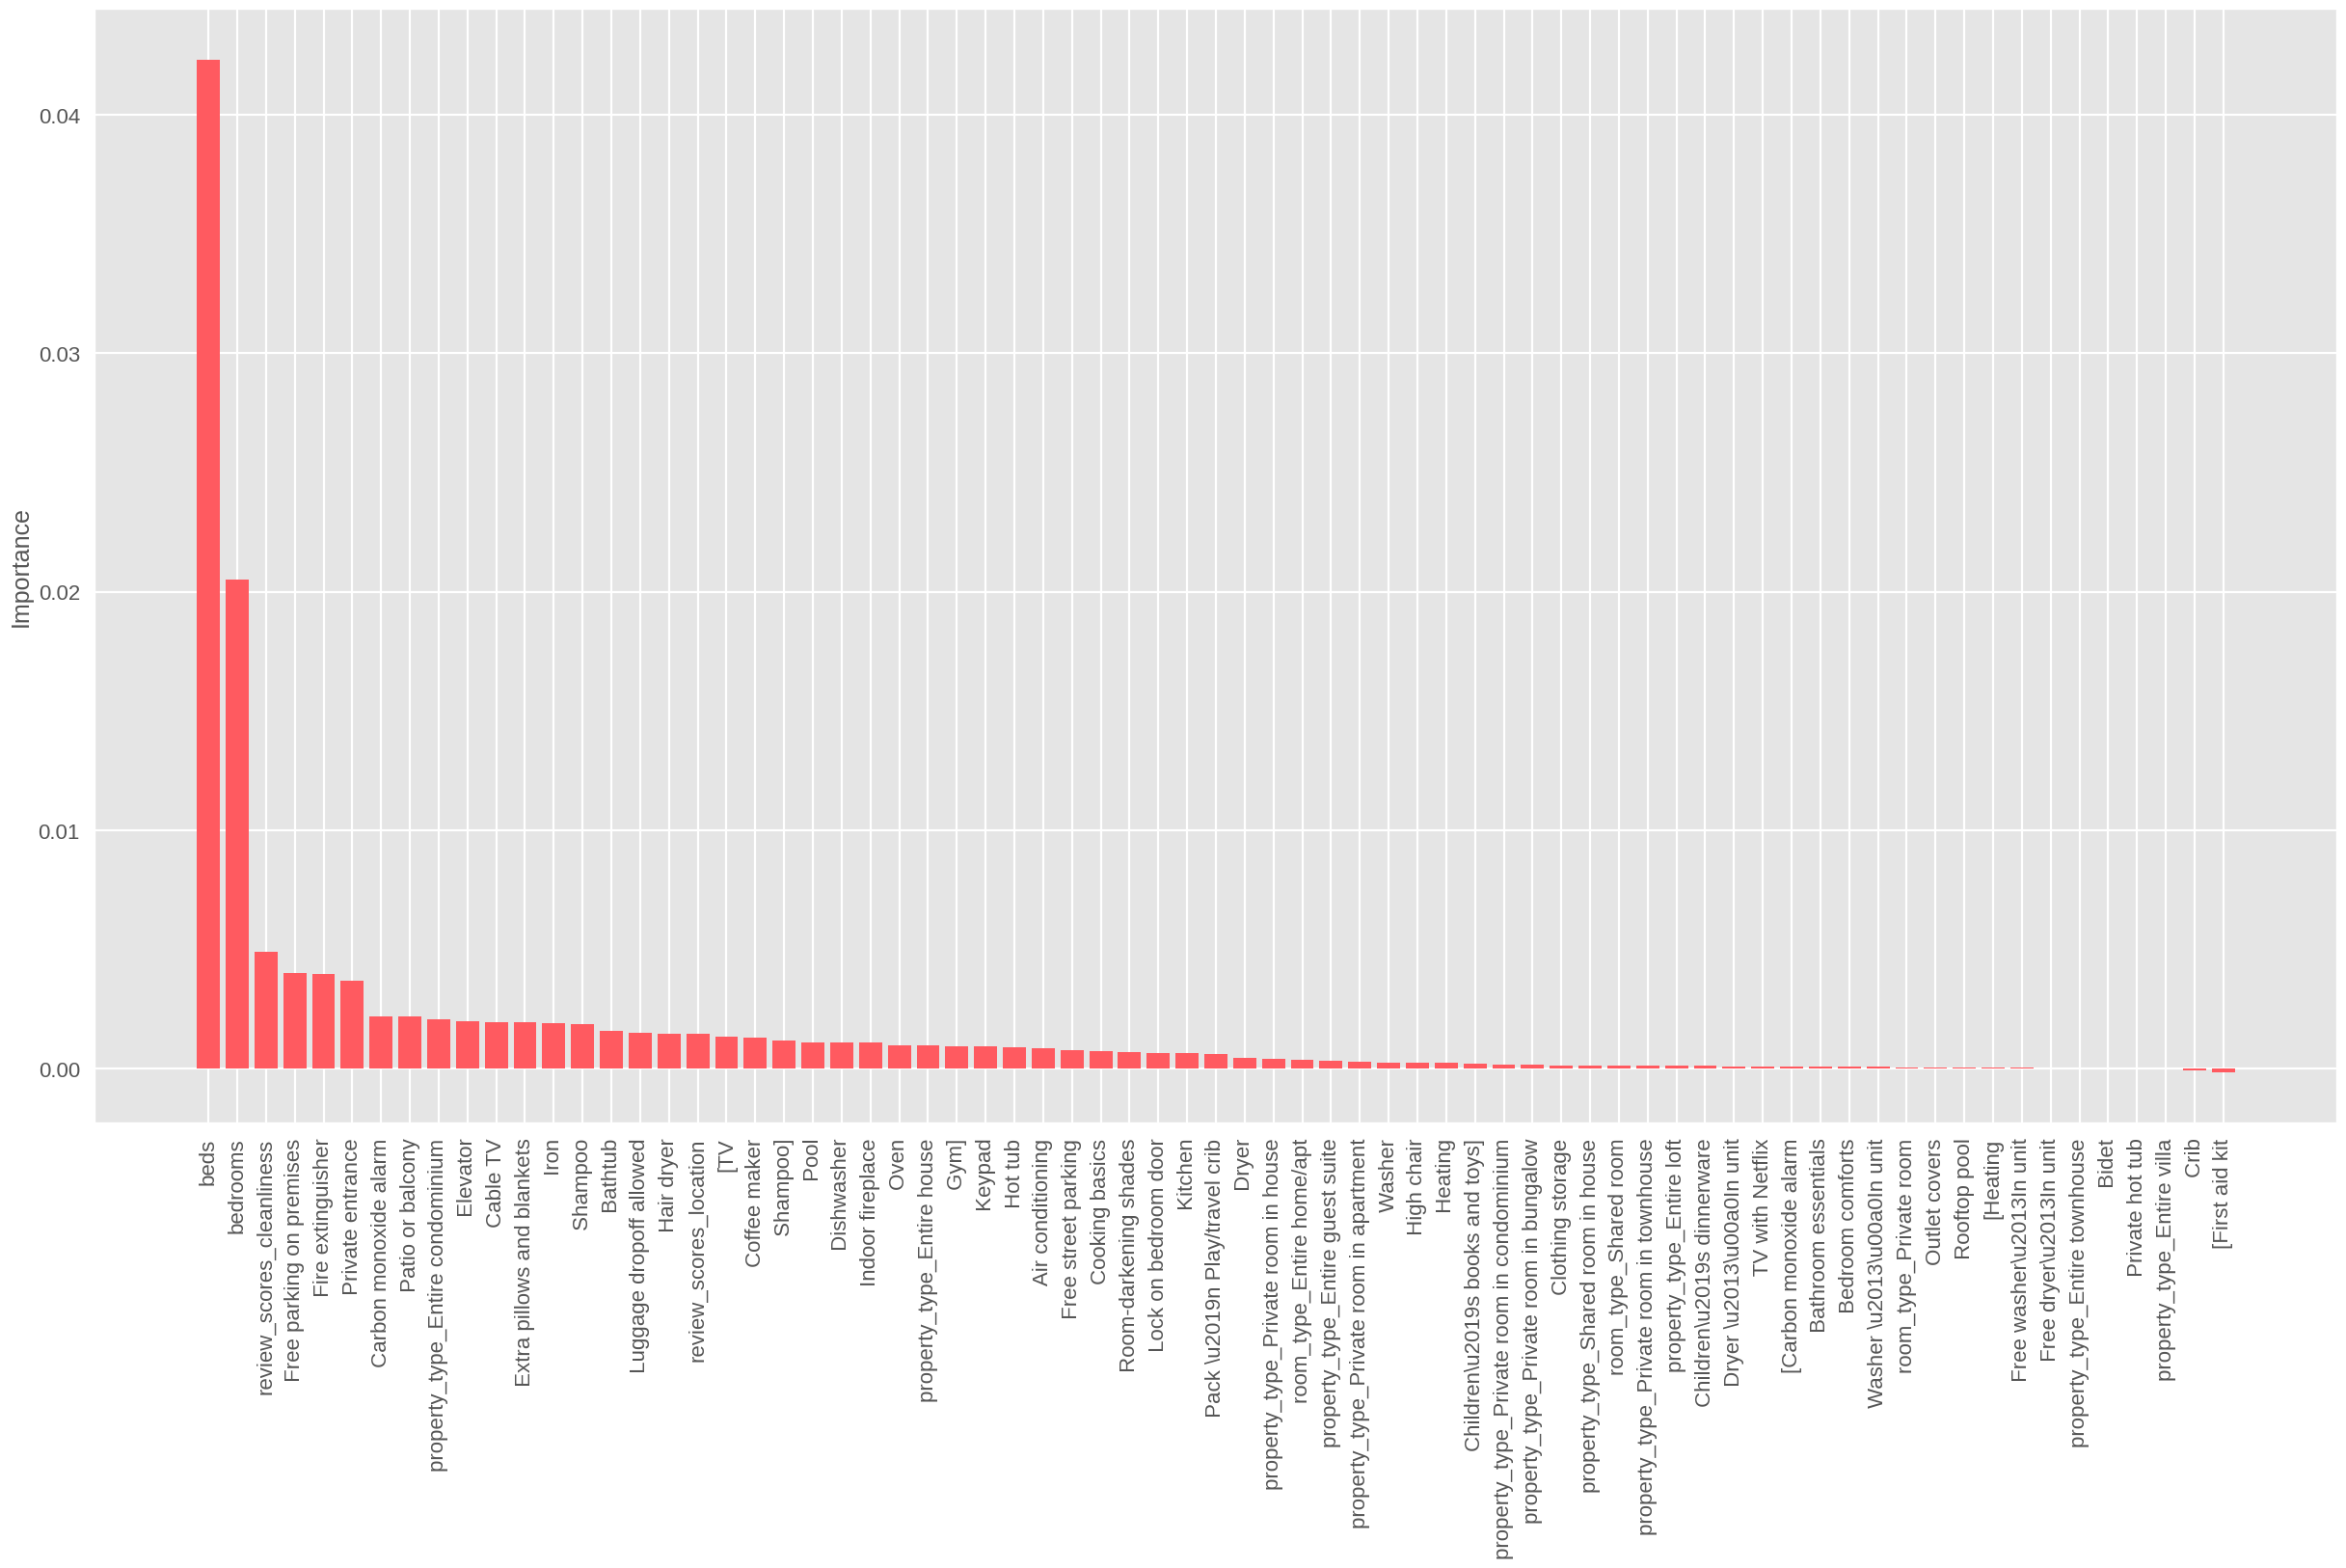

In [ ]:
# Re-do the graph
importance_updated_r = importance_updated.loc[:,0].sort_values(ascending=False)
plt.style.use('ggplot')
plt.rcParams['font.family'] = "sans serif"
plt.figure(figsize=(30, 15))
plt.bar(importance_updated_r.index,importance_updated_r.values,color='#FF5A60')
plt.xticks(rotation=90)
plt.ylabel('Importance', fontsize=18)
plt.show()

In [ ]:

relevant_features_van

In [ ]:
mae_baseline = 0
mape_baseline = 0

In [ ]:
cor = vancouver_input.corr()
cor_target = abs(cor["Cal_price"])
relevant_features = cor_target[cor_target>0.025]
relevant_features_van = vancouver_input[list(relevant_features.index)]
vancouver_ro = outlier_removal(relevant_features_van, 'Cal_price', outlier_pctile=5)

col_drop = ['reviews_per_month','number_of_reviews','review_scores_rating']

vancouver_drop = vancouver_ro.drop(columns=col_drop,errors='ignore')

StdSclr = StandardScaler()
vancouver_sc_update = pd.DataFrame(StdSclr.fit_transform(vancouver_drop))

vancouver_rf, vancouver_X_train, vancouver_y_train = RF_price_model(vancouver_sc_update, vancouver_drop)


Optimised Model
------
RMSE Train Score: 0.8027771219455987
RMSE Test Score: 0.43458753558871144
Mean Absolute error: 40.74
Mean Absolute Percentage error: 32.86
Accuracy: 67.14 %.


In [ ]:
importance_updated = feature_importance(vancouver_rf, vancouver_X_train, vancouver_y_train, vancouver_drop.iloc[:,1:],vancouver_drop.iloc[:,1:].columns, 14)

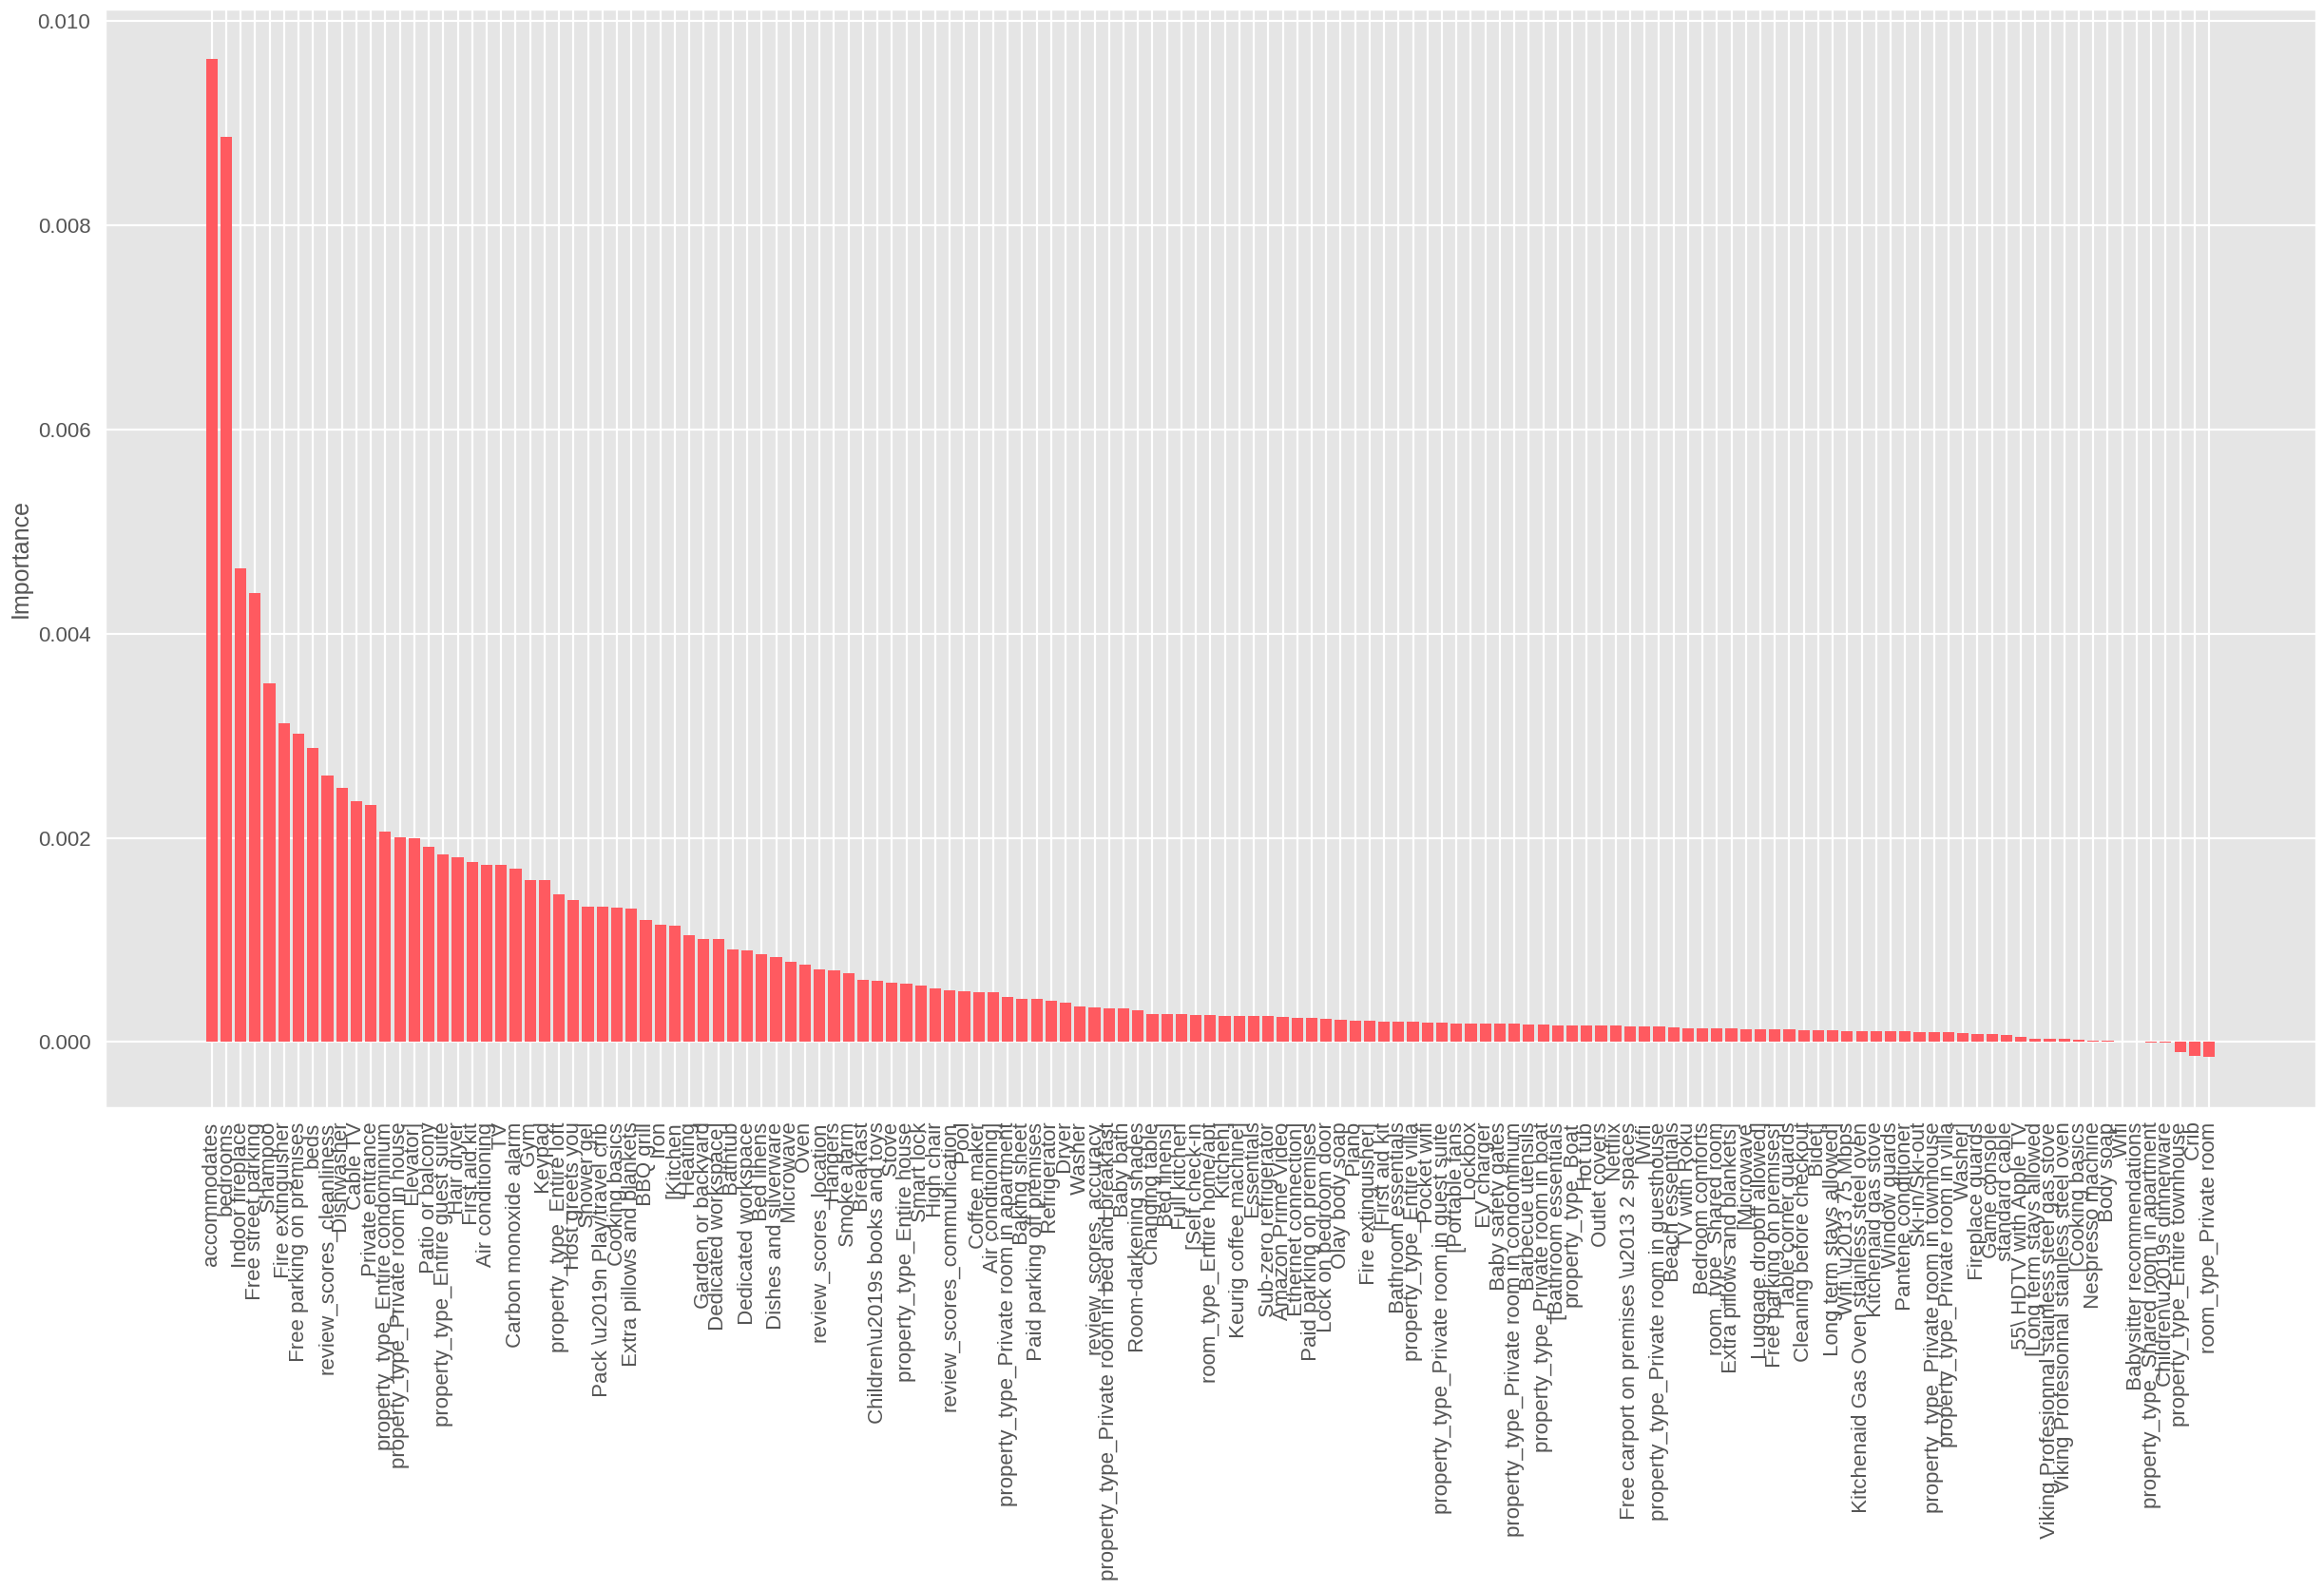

In [ ]:
# plot_feature_importance(importance_updated)
importance_updated_v = importance_updated.loc[:,0].sort_values(ascending=False)
plt.style.use('ggplot')
plt.rcParams['font.family'] = "sans serif"
plt.figure(figsize=(30, 15))
plt.bar(importance_updated_v.index,importance_updated_v.values,color='#FF5A60')
plt.xticks(rotation=90)
plt.ylabel('Importance', fontsize=18)
plt.show()

In [ ]:
col_drop = list(importance_updated[importance_updated[0] < 0].index)
vancouver_drop = vancouver_drop.drop(columns=col_drop)
StdSclr = StandardScaler()
vancouver_sc_update = pd.DataFrame(StdSclr.fit_transform(vancouver_drop))
new_rf, X_train, y_train = RF_price_model(vancouver_sc_update, vancouver_drop)


Optimised Model
------
RMSE Train Score: 0.80547518267804
RMSE Test Score: 0.414988995580824
Mean Absolute error: 40.24
Mean Absolute Percentage error: 30.94
Accuracy: 69.06 %.


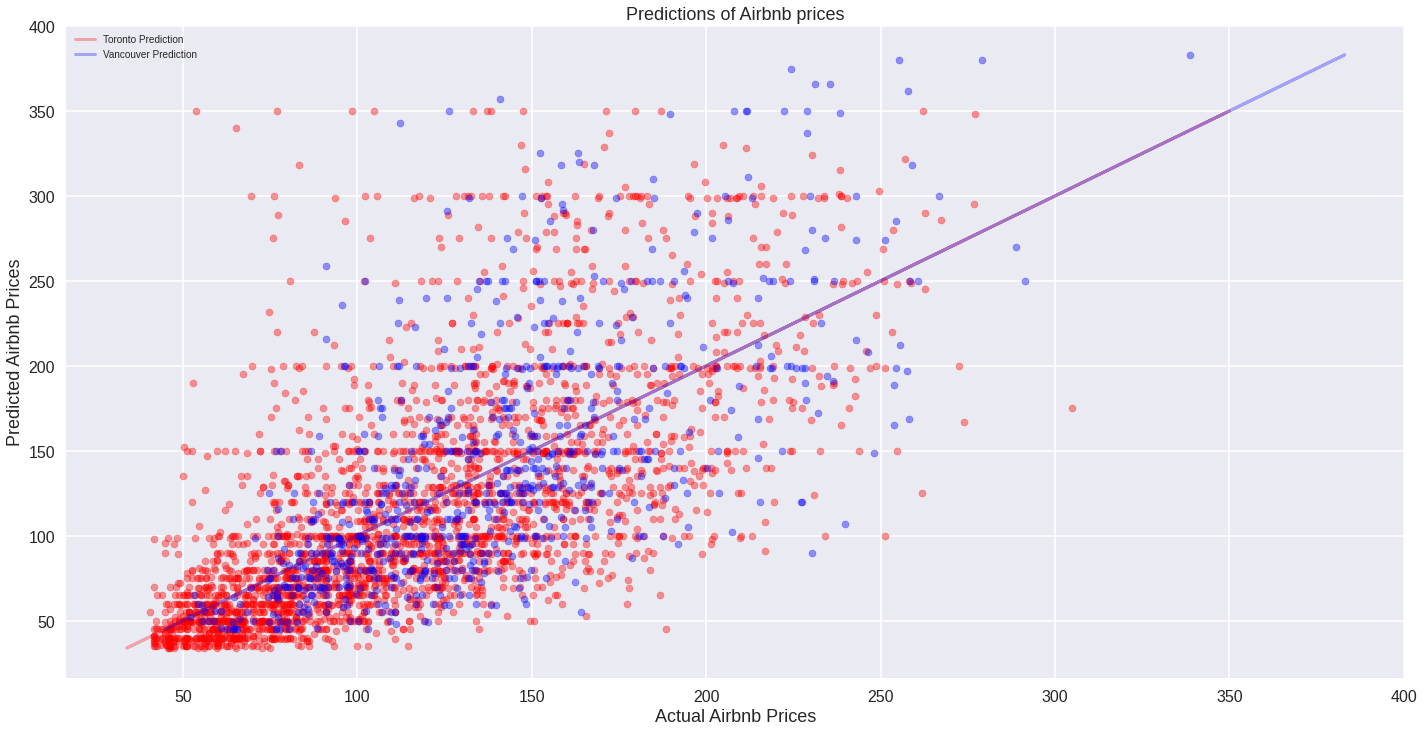

In [ ]:
fig, ax = plt.subplots(figsize=(24,12))

def Airbnb_model(model_input, market, plot=True, color='blue'):

    cor = model_input.corr()
    cor_target = abs(cor["Cal_price"])
    relevant_features = cor_target[cor_target>0.05]

    data_input = model_input[list(relevant_features.index)]
    data_input = outlier_removal(data_input, 'Cal_price', outlier_pctile=5)  

    data_input = data_input.sort_values('Cal_price')
    col_drop = ['reviews_per_month','number_of_reviews','review_scores_rating']
    data_drop = data_input.drop(columns=col_drop,errors='ignore')
    StdSclr = StandardScaler()
    data_scalar = pd.DataFrame(StdSclr.fit_transform(data_drop))
    X = data_scalar.iloc[:,1:]
    Y = data_drop.iloc[:,0].values
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=14, verbose=0,
                      warm_start=False)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    plt.scatter(y_pred, y_test, s=50, color=color, alpha=.4)
    plt.plot(y_test, y_test, label=f'{market} Prediction', color=color, linewidth=3, alpha=.3)

ax.set_title(f"Predictions of Airbnb prices", fontsize=18)


Airbnb_model(toronto_input, 'Toronto', plot=True, color='red')    
Airbnb_model(vancouver_input, 'Vancouver', plot=True, color='blue')

ax.set_ylabel('Predicted Airbnb Prices', fontsize=18)
ax.set_xlabel('Actual Airbnb Prices', fontsize=18)

ax.legend(fontsize=10)


plt.show() 